**PREDIKSI HARGA SAHAM BANK RAKYAT INDONESIA (BRI)**

Oleh: Rizki Alvian

Pada proyek pertama predictive analytics, saya akan melakukan prediksi pada harga saham PT Bank Rakyat Indonesia Tbk (periode data digunakan adalah 2 Juli 2018 sampai 28 Juni 2023) menggunakan algoritma Long Short Term Memory (LSTM).

Data diproleh menggunakan tautan berikut: https://finance.yahoo.com/quote/BBRI.JK/

**Import Library yang Dibutuhkan**

Pertama-tama adalah melakukan iport library yang akan digunakan pada proses prediksi harga saham.

In [1]:
# Import library
import math
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

**Upload Data Yang Akan Digunakan**

Upload dataset yang digunakan kedalam google colab.

In [2]:
# Upload data
from google.colab import files
uploaded = files.upload()

Saving BBRI.JK.csv to BBRI.JK.csv


In [3]:
# Memasukan data csv kedalam variabel dataFrame
import io
dataFrame = pd.read_csv(io.BytesIO(uploaded['BBRI.JK.csv']))

# Menampilkan dataFrame
print(dataFrame.head())
print(dataFrame.tail())

         Date    Open    High     Low   Close    Adj Close     Volume
0  2018-07-02  2890.0  2910.0  2820.0  2850.0  2362.062744  151334600
1  2018-07-03  2850.0  2860.0  2770.0  2830.0  2345.487061   88835200
2  2018-07-04  2830.0  2950.0  2790.0  2930.0  2428.366211  128906900
3  2018-07-05  2890.0  2920.0  2860.0  2910.0  2411.790527   63494300
4  2018-07-06  2910.0  2910.0  2840.0  2840.0  2353.774902   76368500
            Date    Open    High     Low   Close  Adj Close     Volume
1233  2023-06-22  5550.0  5600.0  5475.0  5475.0     5475.0   94143200
1234  2023-06-23  5425.0  5475.0  5400.0  5400.0     5400.0  123350300
1235  2023-06-26  5425.0  5475.0  5375.0  5450.0     5450.0   85472100
1236  2023-06-27  5450.0  5500.0  5425.0  5425.0     5425.0  110716500
1237  2023-06-28  5425.0  5425.0  5425.0  5425.0     5425.0          0


**Exploratory Data Analysis (EDA) dan Visualisasi Data**

Dari tahap proses Exploratory Data Analysis akan diperoleh beberapa insight diantaranya adalah:
*   Jumlah baris data adalah 1239 dengan jumlah  kolom sebanyak 7.
*   Kolom Date bertipe object, sedangkan untuk kolom Open, High, Low, Close, Adj Close, dan Volume bertipe float64.
*   Tidak terdapat Null, yang berarti semua data terisi.

Sedangkan dari tahap Visualisasi Data dapat dilihat pergerakan harga penutupan sahamnya. Disini saya menggunakan data Close atau data harga penutupan saham pada hari itu.

In [4]:
# Exploratory data analysis
print(dataFrame.shape)
print(dataFrame.info())
print(dataFrame.isnull())

(1238, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1238 entries, 0 to 1237
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1238 non-null   object 
 1   Open       1238 non-null   float64
 2   High       1238 non-null   float64
 3   Low        1238 non-null   float64
 4   Close      1238 non-null   float64
 5   Adj Close  1238 non-null   float64
 6   Volume     1238 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 67.8+ KB
None
       Date   Open   High    Low  Close  Adj Close  Volume
0     False  False  False  False  False      False   False
1     False  False  False  False  False      False   False
2     False  False  False  False  False      False   False
3     False  False  False  False  False      False   False
4     False  False  False  False  False      False   False
...     ...    ...    ...    ...    ...        ...     ...
1233  False  False  False  False  False    

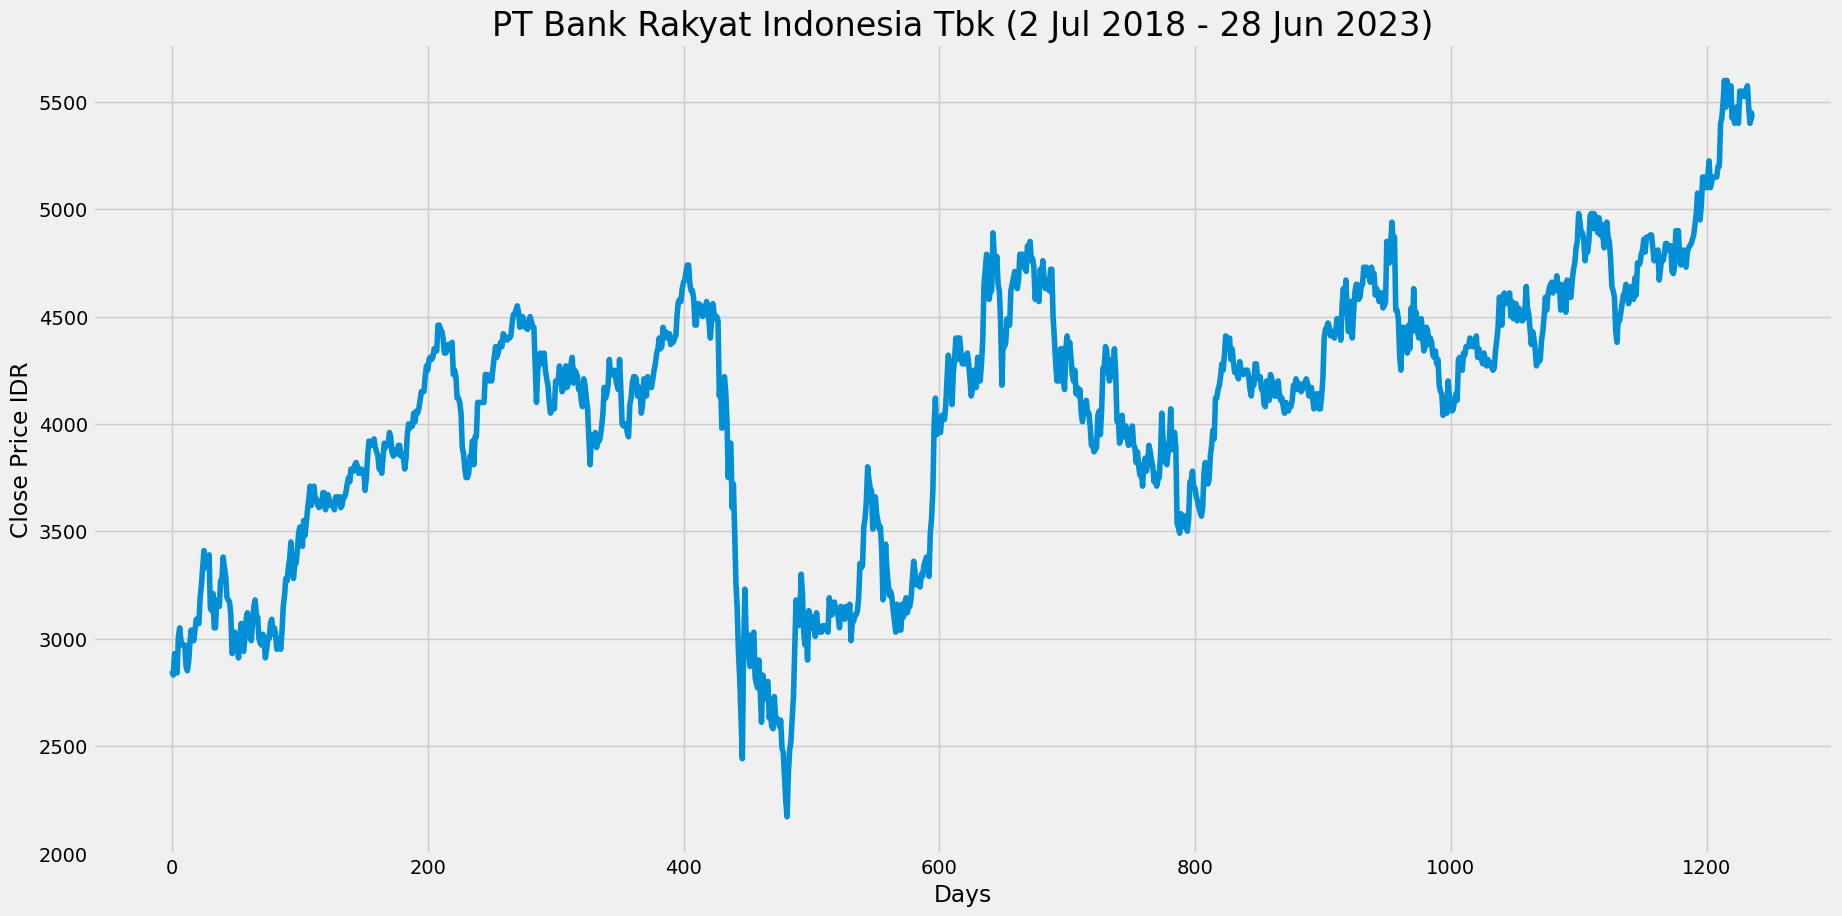

In [5]:
# Visualisasi Data
plt.figure(figsize = (20, 10))
plt.plot(dataFrame['Close'])
plt.title('PT Bank Rakyat Indonesia Tbk (2 Jul 2018 - 28 Jun 2023)',  fontsize = 24)
plt.xlabel('Days')
plt.ylabel('Close Price IDR')
plt.show()

**Mengambil Kolom Close dan Fungsi Split Dataset**

Pada tahapan ini didefinisikan fungsi untuk mengambil kolom Close pada dataFrame, yang akan digunakan dalam proses prediksi harga adalah data penutupan saham, sehingga yang dipilih adalah kolom Close.


Kemudian data diubah menjadi tipe array dan dibagi menjadi data training dan data testing dengan perbandingan 80:20. Dari pembagian ini diperoleh data training sebanyak 992 data.

In [6]:
# Mengambil kolom Close
df = dataFrame.filter(['Close'])

# Convert data kedalam numpy array
dataset = df.values

# Membagi data training dan testing
training_data_len = math.ceil(len(dataset) * .80)
training_data_len

991

**Scaling Dataset**

Data di-scaling kedalam rentang antara 0 hingga 1.

In [7]:
# Scaling the dataset
scaler = MinMaxScaler(feature_range = (0, 1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.19825073],
       [0.19241983],
       [0.22157434],
       ...,
       [0.95626822],
       [0.94897959],
       [0.94897959]])

**Membuat Variabel X Train, Y Train, dan Fungsi Pembagi Data**

Kita definisikan variabel kosong bernama x_train dan y_train, variabel ini akan diisi oleh pembagian data yang akan dilakukan menggunakan data yang sudah di-scaling sebelumnya.

Kemudian data akan dibagi menjadi 60 data x_training yang dimulai dari data dengan index 0 hingga 59 dan 1 data y_train yang diambil dari indeks ke 60. Data dengan indeks 60 tersebut merupakan target dari prediksi setiap 60 data awal yang didefinisikan pada fungsi for di baris kode ke 13. Pembagian selanjutnya adalah data dengan indeks 1 hingga 60 dan data dengan indeks 61, dan begitu seterusnya.

In [8]:
# Membuat dataset training
train_data = scaled_data[0:training_data_len, :]

# Membuay variabel x_train dan y_train
x_train = []
y_train = []

for i in range(60, len(train_data)):
  x_train.append(train_data[i-60:i, 0])
  y_train.append(train_data[i, 0])
  if i <= 61:
    print(x_train)
    print(y_train)

[array([0.19825073, 0.19241983, 0.22157434, 0.21574344, 0.19533528,
       0.24489796, 0.25655977, 0.23906706, 0.23323615, 0.23323615,
       0.23323615, 0.20408163, 0.19825073, 0.20991254, 0.2361516 ,
       0.25364431, 0.24489796, 0.23906706, 0.25364431, 0.26822157,
       0.26530612, 0.26239067, 0.29737609, 0.3148688 , 0.33819242,
       0.36151603, 0.34402332, 0.33819242, 0.33819242, 0.35568513,
       0.28279883, 0.27988338, 0.303207  , 0.25655977, 0.25655977,
       0.29446064, 0.28571429, 0.28571429, 0.32069971, 0.32069971,
       0.35276968, 0.33819242, 0.32653061, 0.29737609, 0.29446064,
       0.29154519, 0.27405248, 0.22157434, 0.2303207 , 0.25072886,
       0.23323615, 0.23323615, 0.21574344, 0.24198251, 0.26239067,
       0.23323615, 0.2244898 , 0.24198251, 0.26822157, 0.27696793])]
[0.2448979591836734]
[array([0.19825073, 0.19241983, 0.22157434, 0.21574344, 0.19533528,
       0.24489796, 0.25655977, 0.23906706, 0.23323615, 0.23323615,
       0.23323615, 0.20408163, 0.1982

**Fungsi Mengubah Menjadi Array dan Fungsi Reshape**

Mendefinisikan fungsi untuk reshape data. Input dari model LSTM mengaruskan untuk array 3 dimensi berupa (number of samples, number of time steps, number of features). Data yang dimiliki masih berbentuk 2 dimensi, jadi harus dilakukan reshaping.

In [9]:
# Convert x_train dan y_train menjadi numpy array
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the dataset
x_train=np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

**Membangun Model dan Fungsi Compile**

* Pertama, manfaatkan library keras.models untuk memanggil fungsi Sequential(), untuk menyiapkan basis model LSTM yang disimpan pada variabel model.
* Kemudian manfaatkan library keras.layer untuk mengkonfigurasikan layer
pada model LSTM, disini kita gunakan konfigurasi 3 layer dengan jumlah neuron
50, 50, dan 25.
* Setelah model selesai dibangun, model akan di-compile dan ditambahkan fungsi optimizer adam.
* Loss function yang digunakan adalah mean_square_error.
* Pada model, dilakukan proses training dengan hyperparameter disetel batch_size = 1 dan epoch = 5.

In [10]:
# Membangun Model LSTM
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences = False))
model.add(Dense(25))
model.add(Dense(1))

# Compile Model LSTM
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = 'mae')

# Training Model LSTM
model.fit(x_train, y_train, batch_size = 1, epochs = 5)

Epoch 1/5
931/931 [==============================] - 33s 31ms/step - loss: 0.0046 - mae: 0.0463
Epoch 2/5
931/931 [==============================] - 30s 33ms/step - loss: 0.0018 - mae: 0.0323
Epoch 3/5
931/931 [==============================] - 31s 33ms/step - loss: 0.0013 - mae: 0.0269
Epoch 4/5
931/931 [==============================] - 29s 31ms/step - loss: 0.0011 - mae: 0.0253
Epoch 5/5
931/931 [==============================] - 29s 31ms/step - loss: 9.9058e-04 - mae: 0.0239


**Membuat Variabel X Test, Y Test, dan Fungsi Pembagi Data**

Disini kita akan medefinisikan variabel kosong bernama x_test dan y_test, yang akan diisi oleh pembagian data yang akan dilakukan menggunakan data yang sudah dibagi dan di-scaling sebelumnya.

Kemudian data akan dibagi menjadi 60 data x_test yang dimulai dari data dengan index 0 hingga 59 (data_testing) dan 1 data y_test (data_testing) yang diambil dari indeks ke 60.

Data dengan indeks 60 tersebut merupakan target dari prediksi setiap 60 data awal didefinisikan pada fungsi for di baris kode ke 9.

Pembagian selanjutnya adalah data dengan indeks 1 hingga 60 dan data dengan indeks 61, dan begitu seterusnya.

In [11]:
# Membuat dataset testing
test_data = scaled_data[training_data_len - 60:, :]

# Membuat dataset x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

**Proses Prediksi**

Input dari model LSTM mengaruskan untuk array 3 dimensi berupa (number of samples, number of time steps, number of features).

Data yang dimiliki masih berbentuk 2 dimensi, jadi harus dilakukan reshaping kemudian data akan dilakukan prediksi. Setelah hasil prediksi didapatkan akan
diterapkan fungsi inverse untuk membalikkan harga seperti semula.

In [12]:
# Convert data kedalam numpy array
x_test = np.array(x_test)

# Reshape dataset
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
x_test.shape

# Memprediksi menggunakan model LSTM
lstm_prediction = model.predict(x_test)

# Melakukan invers data yang sebelumnya di-scalling
lstm_prediction = scaler.inverse_transform(lstm_prediction)

8/8 [==============================] - 1s 20ms/step


**Visualisasi Data**

Berikut adalah visualisasi dari hasil prediksi yang dilakukan menggunakan algoritma LSTM.

<ipython-input-13-a68a5d49405f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = lstm_prediction


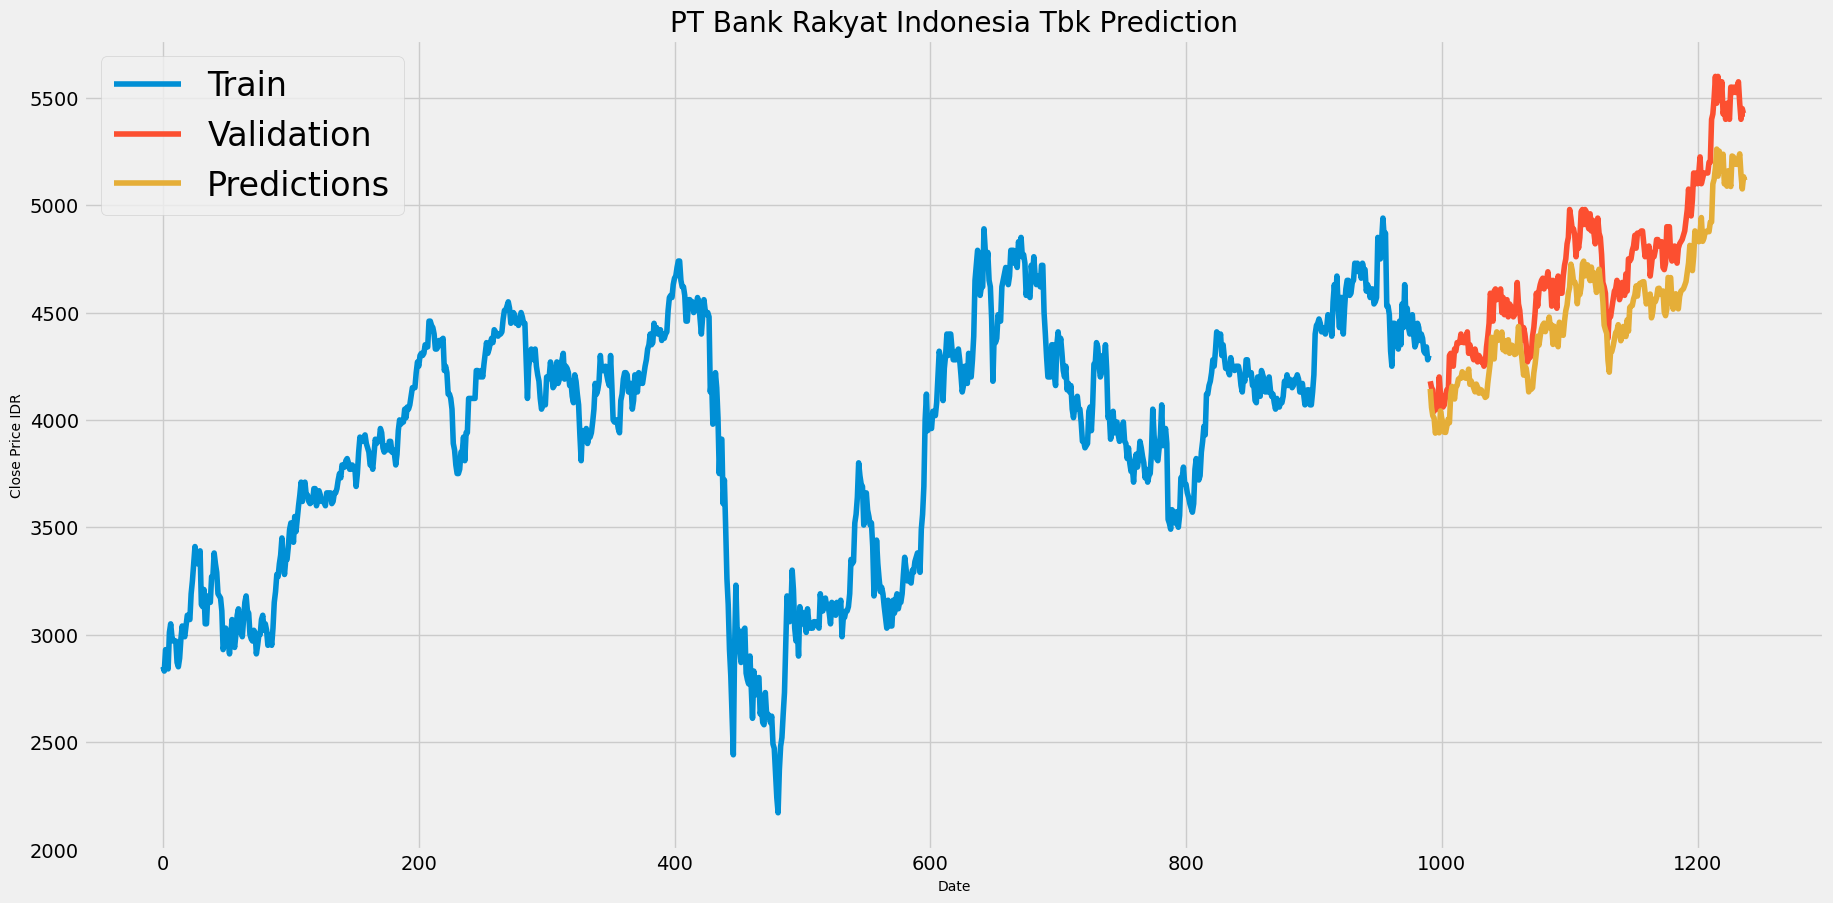

In [13]:
# Plot data
train = df[:training_data_len]
valid = df[training_data_len:]
valid['Predictions'] = lstm_prediction

# Visualisasi data prediksi
plt.figure(figsize = (20, 10))
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.title('PT Bank Rakyat Indonesia Tbk Prediction')
plt.xlabel('Date', fontsize = 10)
plt.ylabel('Close Price IDR', fontsize = 10)
plt.legend(['Train', 'Validation', 'Predictions'], loc = 'best', fontsize = 24)
plt.show()